<b>Download link:</b> https://www.kaggle.com/alxmamaev/flowers-recognition/home

<b>Summary:</b> Classifier built using resnet pretrained model

<b>ref: </b>https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data

In [2]:
import torch
from torchvision import datasets, models, transforms

#### Collecting datasets

Image augmentation and normalization <br>

* Transforms can be chained together using Compose

* In image augmentation I randomly flip images, so the model can detect wrongly oriented images too

* All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]

* First Resize the image to 256 then crop it to 224, so that it doesnt cut important features

ref-https://pytorch.org/docs/stable/torchvision/models.html#id3

In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [4]:
train_transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

test_transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

#### Unzip the images
This will unwrap the contents of flowers_2.zip to the datasets directory. This contains two subdirectories - train and test - which contain the images for training and testing

In [5]:
import zipfile
zip = zipfile.ZipFile('datasets/flowers_2.zip')
zip.extractall('datasets')

In [6]:
data_dir = 'datasets/flowers_2'

In [7]:
image_datasets ={}

#### Use a generic data loader available in pytorch
A call to ImageFolder(Path, Transform) applies our transformations to all the images in the specified directory

In [9]:
image_datasets['train']= datasets.ImageFolder(data_dir + '/train', train_transform)

In [10]:
image_datasets['test']= datasets.ImageFolder(data_dir + '/test', test_transform)

In [11]:
print("Training data size - %d" %  len(image_datasets['train']))
print("Test data size - %d" %  len(image_datasets['test']))

Training data size - 3027
Test data size - 1296


#### Examine the types of flowers in the dataset

In [12]:
class_names = image_datasets['train'].classes
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [13]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 3027
     Root Location: datasets/flowers_2/train
     Transforms (if any): Compose(
                              Resize(size=256, interpolation=PIL.Image.BILINEAR)
                              RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                              RandomHorizontalFlip(p=0.5)
                              ToTensor()
                              Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                          )
     Target Transforms (if any): None,
 'test': Dataset ImageFolder
     Number of datapoints: 1296
     Root Location: datasets/flowers_2/test
     Transforms (if any): Compose(
                              Resize(size=256, interpolation=PIL.Image.BILINEAR)
                              CenterCrop(size=(224, 224))
                              ToTensor()
                              Normalize(mean=[0.485, 0.4

### Data Loaders
Data loader combines a dataset and provides single or multi-process iterators over the dataset
* <b>batch_size</b> = how many samples per batch to load (default: 1).<br>
* <b>shuffle = True</b>, to have the data reshuffled at every epoch <br>
* <b>num_workers= 4</b>, 4 subprocesses will be used for data loading.
0 means that the data will be loaded in the main process. (default: 0)

In [47]:
dataloaders ={}

In [48]:
dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'],
                                                   batch_size=8,
                                                   shuffle=True,
                                                   num_workers=4)

In [49]:
dataloaders['test'] = torch.utils.data.DataLoader(image_datasets['test'],
                                                  batch_size=8,
                                                  shuffle=True,
                                                  num_workers=4)

In [50]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f1122e0d208>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f1122e0d940>}

#### Get a batch of training data
Which we will go on to examine

In [51]:
inputs, labels = next(iter(dataloaders['train']))

#### Check out the shape of this batch of images
The first dimension gives the number of images. The next dimension represents the number of channels. The last two give the image size

In [52]:
inputs.shape

torch.Size([8, 3, 224, 224])

#### Take a look at the labels for this image batch

In [53]:
labels

tensor([1, 3, 0, 1, 2, 2, 4, 4])

#### Create a grid to display the batch of images
torchvision is a module which contains datasets, model architectures and image transformation tools. Here, we use one of its utilities to create a grid of images from our batch 

In [54]:
import torchvision

inp = torchvision.utils.make_grid(inputs)

#### Examine the shape
The grid effectively contains all the 8 images placed side by side with padding of 2 pixels between the images and at the edges of the grid

In [55]:
inp.shape

torch.Size([3, 228, 1810])

#### Examine the maximum pixel value in the batch

In [56]:
inp.max()

tensor(2.6400)

#### Scale the RGB values to be in the [0,1] range
In maltplotlib floating point image RGB values must be in the 0-1 range. To do that we will use np.clip() method

In [57]:
import numpy as np

np.clip(inp, 0, 1).max()

tensor(1.)

#### Transposing the image
Ref - https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow

In [58]:
inp.numpy().transpose((1, 2, 0)).shape

(228, 1810, 3)

#### Use Matplotlib to plot the image grid

In [59]:
import matplotlib.pyplot as plt

plt.ion()

#### Custome function to display the images

In [60]:
def img_show(inp, title=None):
    
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure(figsize=(16,4))
    plt.axis('off')
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)

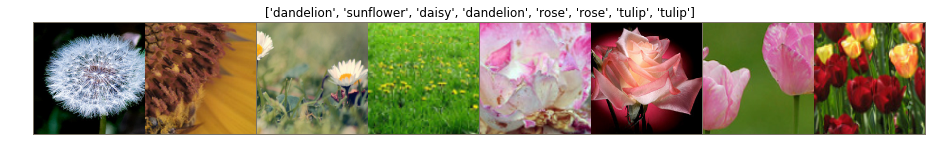

In [61]:
img_show(inp, title=[class_names[x] for x in labels])

#### Load the Resnet pretrained model

In [62]:
model = models.resnet18(pretrained=True)

#### Check the input feature size for our linear layer
The final layer of pre-trained model will be the input to a final Linear layer we need to add. To get the number of input features for linear layer, check the value of model.fc.in_features

In [63]:
num_ftrs = model.fc.in_features
num_ftrs

512

In [64]:
import torch.nn as nn

#### Adding last layer,
We have 5 discrete output labels, hence last layer must 5 output neurons(nodes)

In [65]:
model.fc = nn.Linear(num_ftrs, 5)

#### The criterion to minimize in the loss function

In [66]:
criterion = nn.CrossEntropyLoss()

### Set up the optimizer
define a simple SGD optimizer with momentum which accelerate gradients vectors in the right directions and hence leads to faster converging

In [67]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), 
                      lr=0.001, 
                      momentum=0.9)

#### Decay Learning Rate by a factor of 0.1 every 7 epochs
This will speed up the computation as we don't need the same learning rate while getting closer to convergence

In [68]:
from torch.optim import lr_scheduler

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, 
                                       step_size=7, 
                                       gamma=0.1)

#### A function to calculate the loss and accuracy of our model
calculate_accuracy will calculate loss and accuracy per epoch and will be used in training as well as while testing

In [69]:
def calculate_accuracy(phase, running_loss, running_corrects):

    epoch_loss = running_loss / len(image_datasets[phase])
    epoch_acc = running_corrects.double() / len(image_datasets[phase])

    print('{} Loss: {:.4f} Acc: {:.4f}'.format( phase, epoch_loss, epoch_acc))
    
    return (epoch_loss, epoch_acc)

#### Define the training phase
This will be the training operation performed at each epoch

* <b>scheduler.step()</b> will set up the scheduler for each step in order to decay the learning rate
* <b>model.train()</b> will set the pre-trained model into training mode. This is only available for pre-trained models
* <b>running_loss</b> will keep track of the loss at each iteration
* <b>running_corrects</b> keeps a count of the number of correct predictions which will be used to calculate the accuracy of the model
<br />
* By setting <b>torch.set_grad_enabled(True)</b> we are enabling Autograd
* <b>outputs</b> is the list probabilities for each possible label for the batch of images (which are the inputs). We use torch.max() to get the index of the highest probability label for each image in the batch

In [70]:
def phase_train(model, criterion, optimizer, scheduler):
    
    scheduler.step()
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    
    for inputs, labels in dataloaders['train']:

        optimizer.zero_grad()
        
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    calculate_accuracy('train', running_loss, running_corrects) 

In [71]:
import copy

In [72]:
best_acc = 0.0

#### Define the test phase
This will be the test operation performed at each epoch

* <b>model.eval()</b> will set the pre-trained model into evaluation mode. This is only available for pre-trained models
* <b>running_loss</b> will keep track of the loss at each iteration
* <b>running_corrects</b> keeps a count of the number of correct predictions which will be used to calculate the accuracy of the model
<br />
* By setting <b>torch.no_grad()</b> we are disabling Autograd
* <b>outputs</b> is the list probabilities for each possible label for the batch of images (which are the inputs). We use torch.max() to get the index of the highest probability label for each image in the batch
<br />

Once the accuracy is calculated, we check to see if the accuracy in this has improved since the previous epoch. If not, we do not adjust the weights of the model. If so, we set the weights of the model to be the ones calculated in this epoch and return those values

In [73]:
def phase_test(model, criterion, optimizer):
    
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    global best_acc
    
    for inputs, labels in dataloaders['test']:

        optimizer.zero_grad()
        
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss, epoch_acc = calculate_accuracy('test', running_loss, running_corrects)
    
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        
    return best_model_wts

#### We build upon our pre-trained model
* we initialize the <b>best_model_wts</b> from the weights of the pre-trained model
* perform the training and testing and update the model weights if it has supplied improved accuracy in the epoch

In [74]:
def build_model(model, criterion, optimizer, scheduler, num_epochs=10):
    
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        phase_train(model, criterion, optimizer, scheduler)
        best_model_wts = phase_test(model, criterion, optimizer)
        print()
    
    print('Best test Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

#### Call the build_model function
I set the number of epochs to 1 here, as it takes about 30 minutes for this model to be built. When running on a cloud platform VM with a GPU, I was able to run about 6 epochs and got accuracy levels upwards of 90%

In [75]:
model = build_model(model, 
                    criterion, 
                    optimizer, 
                    exp_lr_scheduler, 
                    num_epochs=1)

Epoch 0/0
----------
train Loss: 0.7054 Acc: 0.7337
test Loss: 0.4027 Acc: 0.8480

Best test Acc: 0.847994


#### Lets check how our model performs
I will take one batch from test datasets (and I have batches of 8 images) and will predict the correct label


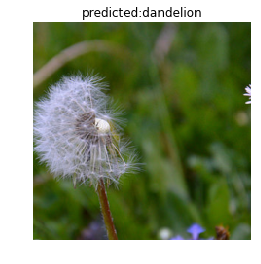

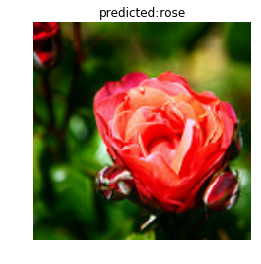

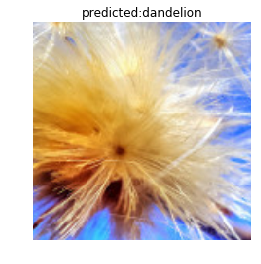

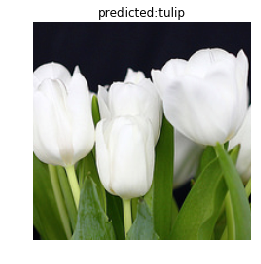

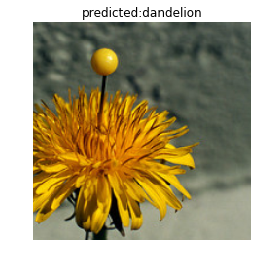

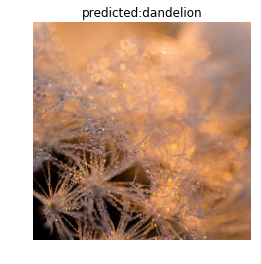

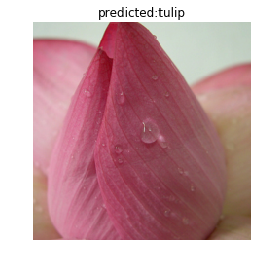

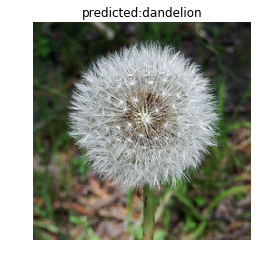

In [76]:
with torch.no_grad():
    
    inputs, labels = iter(dataloaders['test']).next()
    inp = torchvision.utils.make_grid(inputs)
    
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    
    for j in range(len(inputs)):
        inp = inputs.data[j]
        img_show(inp, 'predicted:' + class_names[preds[j]])